In [1]:
%matplotlib widget

In [2]:
import numpy as np
import xtrack as xt
import matplotlib.pyplot as plt

In [3]:
env = xt.Environment()
env.call('../fccee_z_lattice.py')

env['rf_on'] = 0

In [4]:
env.vars.load_json('strengths_quads_00_arc_cell.json')
env.vars.load_json('strengths_quads_01_ffccsyl.json')
env.vars.load_json('strengths_quads_02_ffccsxl.json')
env.vars.load_json('strengths_quads_03_ffccsyr.json')
env.vars.load_json('strengths_quads_04_ffccsxr.json')
env.vars.load_json('strengths_quads_05_ffds_lr.json')
env.vars.load_json('strengths_quads_06_straight.json')

env.vars.load_json('strengths_sext_00_arc_cell.json')
env.vars.load_json('strengths_sext_01_straight.json')
env.vars.load_json('strengths_sext_02_final_focus.json')

In [5]:
line = env['fccee_p_ring']

In [6]:
tw = line.twiss4d()

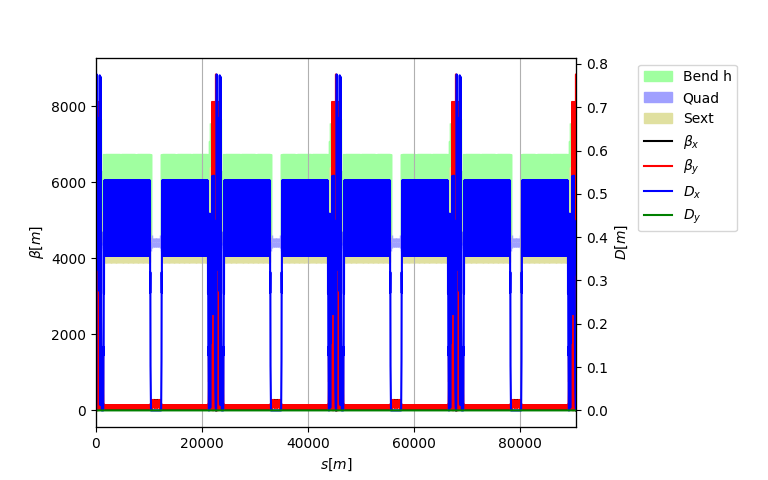

In [7]:
tw.plot()

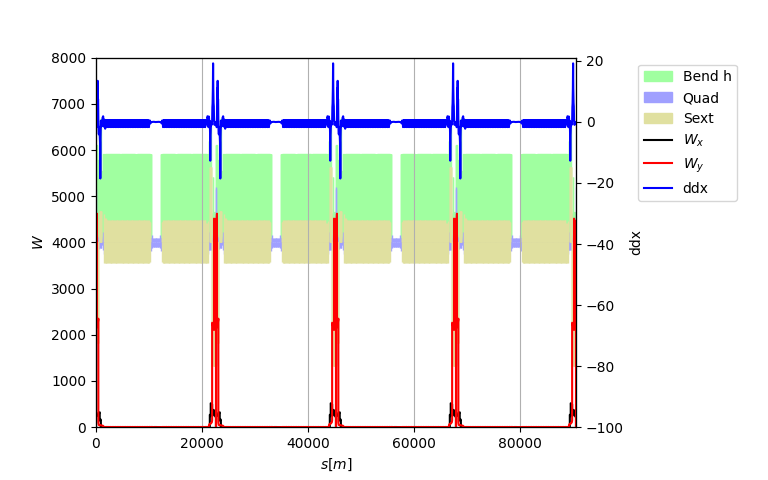

In [10]:
pp = tw.plot(yl='wx_chrom wy_chrom', yr='ddx')
pp.ylim(left_lo=0, left_hi=8000, right_lo=-100)

In [11]:
line.replace_all_repeated_elements()

In [17]:
tw_ng = line.madng_twiss(rdts=['f1200', 'f2100', 'f3000'])

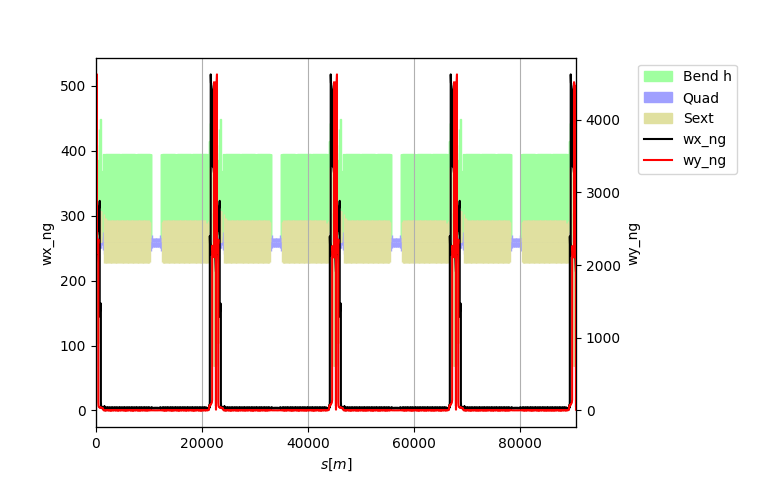

In [20]:
tw_ng.plot('abs(f1200) abs(f2100) abs(f3000)')